In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Render a textured mesh

This tutorial shows how to:
- load a mesh and textures from an `.obj` file. 
- set up a renderer 
- render the mesh 
- vary the rendering settings such as lighting and camera position
- use the batching features of the pytorch3d API to render the mesh from different viewpoints

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [4]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [5]:
from utils import image_grid

# Bumpmap texture definition

In [6]:
# from typing import TYPE_CHECKING, Dict, List, Optional, Tuple, Union

# from pytorch3d.ops import interpolate_face_attributes
# from pytorch3d.structures.utils import list_to_packed, list_to_padded, padded_to_list
# from torch.nn.functional import interpolate

# class NormalMapsUV(TexturesBase):
#     def __init__(
#         self,
#         maps: Union[torch.Tensor, List[torch.Tensor]],
#         faces_uvs: Union[torch.Tensor, List[torch.Tensor], Tuple[torch.Tensor]],
#         verts_uvs: Union[torch.Tensor, List[torch.Tensor], Tuple[torch.Tensor]],
#         padding_mode: str = "border",
#         align_corners: bool = True,
#     ) -> None:
#         """
#         Textures are represented as a per mesh texture map and uv coordinates for each
#         vertex in each face. NOTE: this class only supports one texture map per mesh.

#         Args:
#             maps: texture map per mesh. This can either be a list of maps
#               [(H, W, C)] or a padded tensor of shape (N, H, W, C).
#               For RGB, C = 3.
#             faces_uvs: (N, F, 3) LongTensor giving the index into verts_uvs
#                         for each face
#             verts_uvs: (N, V, 2) tensor giving the uv coordinates per vertex
#                         (a FloatTensor with values between 0 and 1).
#             align_corners: If true, the extreme values 0 and 1 for verts_uvs
#                             indicate the centers of the edge pixels in the maps.
#             padding_mode: padding mode for outside grid values
#                                 ("zeros", "border" or "reflection").

#         The align_corners and padding_mode arguments correspond to the arguments
#         of the `grid_sample` torch function. There is an informative illustration of
#         the two align_corners options at
#         https://discuss.pytorch.org/t/22663/9 .

#         An example of how the indexing into the maps, with align_corners=True,
#         works is as follows.
#         If maps[i] has shape [1001, 101] and the value of verts_uvs[i][j]
#         is [0.4, 0.3], then a value of j in faces_uvs[i] means a vertex
#         whose color is given by maps[i][700, 40]. padding_mode affects what
#         happens if a value in verts_uvs is less than 0 or greater than 1.
#         Note that increasing a value in verts_uvs[..., 0] increases an index
#         in maps, whereas increasing a value in verts_uvs[..., 1] _decreases_
#         an _earlier_ index in maps.

#         If align_corners=False, an example would be as follows.
#         If maps[i] has shape [1000, 100] and the value of verts_uvs[i][j]
#         is [0.405, 0.2995], then a value of j in faces_uvs[i] means a vertex
#         whose color is given by maps[i][700, 40].
#         When align_corners=False, padding_mode even matters for values in
#         verts_uvs slightly above 0 or slightly below 1. In this case, the
#         padding_mode matters if the first value is outside the interval
#         [0.0005, 0.9995] or if the second is outside the interval
#         [0.005, 0.995].
#         """
#         self.padding_mode = padding_mode
#         self.align_corners = align_corners
#         if isinstance(faces_uvs, (list, tuple)):
#             for fv in faces_uvs:
#                 if fv.ndim != 2 or fv.shape[-1] != 3:
#                     msg = "Expected faces_uvs to be of shape (F, 3); got %r"
#                     raise ValueError(msg % repr(fv.shape))
#             self._faces_uvs_list = faces_uvs
#             self._faces_uvs_padded = None
#             self.device = torch.device("cpu")

#             # These values may be overridden when textures is
#             # passed into the Meshes constructor. For more details
#             # refer to the __init__ of Meshes.
#             self._N = len(faces_uvs)
#             self._num_faces_per_mesh = [len(fv) for fv in faces_uvs]

#             if self._N > 0:
#                 self.device = faces_uvs[0].device

#         elif torch.is_tensor(faces_uvs):
#             if faces_uvs.ndim != 3 or faces_uvs.shape[-1] != 3:
#                 msg = "Expected faces_uvs to be of shape (N, F, 3); got %r"
#                 raise ValueError(msg % repr(faces_uvs.shape))
#             self._faces_uvs_padded = faces_uvs
#             self._faces_uvs_list = None
#             self.device = faces_uvs.device

#             # These values may be overridden when textures is
#             # passed into the Meshes constructor. For more details
#             # refer to the __init__ of Meshes.
#             self._N = len(faces_uvs)
#             max_F = faces_uvs.shape[1]
#             self._num_faces_per_mesh = [max_F] * self._N
#         else:
#             raise ValueError("Expected faces_uvs to be a tensor or list")

#         if isinstance(verts_uvs, (list, tuple)):
#             for fv in verts_uvs:
#                 if fv.ndim != 2 or fv.shape[-1] != 2:
#                     msg = "Expected verts_uvs to be of shape (V, 2); got %r"
#                     raise ValueError(msg % repr(fv.shape))
#             self._verts_uvs_list = verts_uvs
#             self._verts_uvs_padded = None

#             if len(verts_uvs) != self._N:
#                 raise ValueError(
#                     "verts_uvs and faces_uvs must have the same batch dimension"
#                 )
#             if not all(v.device == self.device for v in verts_uvs):
#                 raise ValueError("verts_uvs and faces_uvs must be on the same device")

#         elif torch.is_tensor(verts_uvs):
#             if (
#                 verts_uvs.ndim != 3
#                 or verts_uvs.shape[-1] != 2
#                 or verts_uvs.shape[0] != self._N
#             ):
#                 msg = "Expected verts_uvs to be of shape (N, V, 2); got %r"
#                 raise ValueError(msg % repr(verts_uvs.shape))
#             self._verts_uvs_padded = verts_uvs
#             self._verts_uvs_list = None

#             if verts_uvs.device != self.device:
#                 raise ValueError("verts_uvs and faces_uvs must be on the same device")
#         else:
#             raise ValueError("Expected verts_uvs to be a tensor or list")

#         if isinstance(maps, (list, tuple)):
#             self._maps_list = maps
#         else:
#             self._maps_list = None
#         self._maps_padded = self._format_maps_padded(maps)

#         if self._maps_padded.device != self.device:
#             raise ValueError("maps must be on the same device as verts/faces uvs.")

#         self.valid = torch.ones((self._N,), dtype=torch.bool, device=self.device)

#     def _format_maps_padded(
#         self, maps: Union[torch.Tensor, List[torch.Tensor]]
#     ) -> torch.Tensor:
#         if isinstance(maps, torch.Tensor):
#             if maps.ndim != 4 or maps.shape[0] != self._N:
#                 msg = "Expected maps to be of shape (N, H, W, C); got %r"
#                 raise ValueError(msg % repr(maps.shape))
#             return maps

#         if isinstance(maps, (list, tuple)):
#             if len(maps) != self._N:
#                 raise ValueError("Expected one texture map per mesh in the batch.")
#             if self._N > 0:
#                 if not all(map.ndim == 3 for map in maps):
#                     raise ValueError("Invalid number of dimensions in texture maps")
#                 if not all(map.shape[2] == maps[0].shape[2] for map in maps):
#                     raise ValueError("Inconsistent number of channels in maps")
#                 maps_padded = _pad_texture_maps(maps, align_corners=self.align_corners)
#             else:
#                 maps_padded = torch.empty(
#                     (self._N, 0, 0, 3), dtype=torch.float32, device=self.device
#                 )
#             return maps_padded

#         raise ValueError("Expected maps to be a tensor or list of tensors.")

#     def clone(self) -> "NormalMapsUV":
#         tex = self.__class__(
#             self.maps_padded().clone(),
#             self.faces_uvs_padded().clone(),
#             self.verts_uvs_padded().clone(),
#         )
#         if self._maps_list is not None:
#             tex._maps_list = [m.clone() for m in self._maps_list]
#         if self._verts_uvs_list is not None:
#             tex._verts_uvs_list = [v.clone() for v in self._verts_uvs_list]
#         if self._faces_uvs_list is not None:
#             tex._faces_uvs_list = [f.clone() for f in self._faces_uvs_list]
#         num_faces = (
#             self._num_faces_per_mesh.clone()
#             if torch.is_tensor(self._num_faces_per_mesh)
#             else self._num_faces_per_mesh
#         )
#         tex._num_faces_per_mesh = num_faces
#         tex.valid = self.valid.clone()
#         return tex

#     def detach(self) -> "NormalMapsUV":
#         tex = self.__class__(
#             self.maps_padded().detach(),
#             self.faces_uvs_padded().detach(),
#             self.verts_uvs_padded().detach(),
#         )
#         if self._maps_list is not None:
#             tex._maps_list = [m.detach() for m in self._maps_list]
#         if self._verts_uvs_list is not None:
#             tex._verts_uvs_list = [v.detach() for v in self._verts_uvs_list]
#         if self._faces_uvs_list is not None:
#             tex._faces_uvs_list = [f.detach() for f in self._faces_uvs_list]
#         num_faces = (
#             self._num_faces_per_mesh.detach()
#             if torch.is_tensor(self._num_faces_per_mesh)
#             else self._num_faces_per_mesh
#         )
#         tex._num_faces_per_mesh = num_faces
#         tex.valid = self.valid.detach()
#         return tex

#     def __getitem__(self, index) -> "NormalMapsUV":
#         props = ["verts_uvs_list", "faces_uvs_list", "maps_list", "_num_faces_per_mesh"]
#         new_props = self._getitem(index, props)
#         faces_uvs = new_props["faces_uvs_list"]
#         verts_uvs = new_props["verts_uvs_list"]
#         maps = new_props["maps_list"]

#         # if index has multiple values then faces/verts/maps may be a list of tensors
#         if all(isinstance(f, (list, tuple)) for f in [faces_uvs, verts_uvs, maps]):
#             new_tex = self.__class__(
#                 faces_uvs=faces_uvs,
#                 verts_uvs=verts_uvs,
#                 maps=maps,
#                 padding_mode=self.padding_mode,
#                 align_corners=self.align_corners,
#             )
#         elif all(torch.is_tensor(f) for f in [faces_uvs, verts_uvs, maps]):
#             new_tex = self.__class__(
#                 faces_uvs=[faces_uvs],
#                 verts_uvs=[verts_uvs],
#                 maps=[maps],
#                 padding_mode=self.padding_mode,
#                 align_corners=self.align_corners,
#             )
#         else:
#             raise ValueError("Not all values are provided in the correct format")
#         new_tex._num_faces_per_mesh = new_props["_num_faces_per_mesh"]
#         return new_tex

#     def faces_uvs_padded(self) -> torch.Tensor:
#         if self._faces_uvs_padded is None:
#             if self.isempty():
#                 self._faces_uvs_padded = torch.zeros(
#                     (self._N, 0, 3), dtype=torch.float32, device=self.device
#                 )
#             else:
#                 self._faces_uvs_padded = list_to_padded(
#                     self._faces_uvs_list, pad_value=0.0
#                 )
#         return self._faces_uvs_padded

#     def faces_uvs_list(self) -> List[torch.Tensor]:
#         if self._faces_uvs_list is None:
#             if self.isempty():
#                 self._faces_uvs_list = [
#                     torch.empty((0, 3), dtype=torch.float32, device=self.device)
#                 ] * self._N
#             else:
#                 self._faces_uvs_list = padded_to_list(
#                     self._faces_uvs_padded, split_size=self._num_faces_per_mesh
#                 )
#         return self._faces_uvs_list

#     def verts_uvs_padded(self) -> torch.Tensor:
#         if self._verts_uvs_padded is None:
#             if self.isempty():
#                 self._verts_uvs_padded = torch.zeros(
#                     (self._N, 0, 2), dtype=torch.float32, device=self.device
#                 )
#             else:
#                 self._verts_uvs_padded = list_to_padded(
#                     self._verts_uvs_list, pad_value=0.0
#                 )
#         return self._verts_uvs_padded

#     def verts_uvs_list(self) -> List[torch.Tensor]:
#         if self._verts_uvs_list is None:
#             if self.isempty():
#                 self._verts_uvs_list = [
#                     torch.empty((0, 2), dtype=torch.float32, device=self.device)
#                 ] * self._N
#             else:
#                 # The number of vertices in the mesh and in verts_uvs can differ
#                 # e.g. if a vertex is shared between 3 faces, it can
#                 # have up to 3 different uv coordinates.
#                 self._verts_uvs_list = list(self._verts_uvs_padded.unbind(0))
#         return self._verts_uvs_list

#     # Currently only the padded maps are used.
#     def maps_padded(self) -> torch.Tensor:
#         return self._maps_padded

#     def maps_list(self) -> List[torch.Tensor]:
#         if self._maps_list is not None:
#             return self._maps_list
#         return self._maps_padded.unbind(0)

#     def extend(self, N: int) -> "NormalMapsUV":
#         new_props = self._extend(
#             N,
#             [
#                 "maps_padded",
#                 "verts_uvs_padded",
#                 "faces_uvs_padded",
#                 "_num_faces_per_mesh",
#             ],
#         )
#         new_tex = self.__class__(
#             maps=new_props["maps_padded"],
#             faces_uvs=new_props["faces_uvs_padded"],
#             verts_uvs=new_props["verts_uvs_padded"],
#             padding_mode=self.padding_mode,
#             align_corners=self.align_corners,
#         )

#         new_tex._num_faces_per_mesh = new_props["_num_faces_per_mesh"]
#         return new_tex

#     def sample_textures(self, fragments, **kwargs) -> torch.Tensor:
#         """
#         Interpolate a 2D texture map using uv vertex texture coordinates for each
#         face in the mesh. First interpolate the vertex uvs using barycentric coordinates
#         for each pixel in the rasterized output. Then interpolate the texture map
#         using the uv coordinate for each pixel.

#         Args:
#             fragments:
#                 The outputs of rasterization. From this we use

#                 - pix_to_face: LongTensor of shape (N, H, W, K) specifying the indices
#                 of the faces (in the packed representation) which
#                 overlap each pixel in the image.
#                 - barycentric_coords: FloatTensor of shape (N, H, W, K, 3) specifying
#                 the barycentric coordinates of each pixel
#                 relative to the faces (in the packed
#                 representation) which overlap the pixel.

#         Returns:
#             texels: tensor of shape (N, H, W, K, C) giving the interpolated
#             texture for each pixel in the rasterized image.
#         """
#         if self.isempty():
#             faces_verts_uvs = torch.zeros(
#                 (self._N, 3, 2), dtype=torch.float32, device=self.device
#             )
#         else:
#             packing_list = [
#                 i[j] for i, j in zip(self.verts_uvs_list(), self.faces_uvs_list())
#             ]
#             faces_verts_uvs = torch.cat(packing_list)
#         texture_maps = self.maps_padded()

#         # pixel_uvs: (N, H, W, K, 2)
#         pixel_uvs = interpolate_face_attributes(
#             fragments.pix_to_face, fragments.bary_coords, faces_verts_uvs
#         )

#         N, H_out, W_out, K = fragments.pix_to_face.shape
#         N, H_in, W_in, C = texture_maps.shape  # 3 for RGB

#         # pixel_uvs: (N, H, W, K, 2) -> (N, K, H, W, 2) -> (NK, H, W, 2)
#         pixel_uvs = pixel_uvs.permute(0, 3, 1, 2, 4).reshape(N * K, H_out, W_out, 2)

#         # textures.map:
#         #   (N, H, W, C) -> (N, C, H, W) -> (1, N, C, H, W)
#         #   -> expand (K, N, C, H, W) -> reshape (N*K, C, H, W)
#         texture_maps = (
#             texture_maps.permute(0, 3, 1, 2)[None, ...]
#             .expand(K, -1, -1, -1, -1)
#             .transpose(0, 1)
#             .reshape(N * K, C, H_in, W_in)
#         )

#         # Textures: (N*K, C, H, W), pixel_uvs: (N*K, H, W, 2)
#         # Now need to format the pixel uvs and the texture map correctly!
#         # From pytorch docs, grid_sample takes `grid` and `input`:
#         #   grid specifies the sampling pixel locations normalized by
#         #   the input spatial dimensions It should have most
#         #   values in the range of [-1, 1]. Values x = -1, y = -1
#         #   is the left-top pixel of input, and values x = 1, y = 1 is the
#         #   right-bottom pixel of input.

#         pixel_uvs = pixel_uvs * 2.0 - 1.0

#         texture_maps = torch.flip(texture_maps, [2])  # flip y axis of the texture map
#         if texture_maps.device != pixel_uvs.device:
#             texture_maps = texture_maps.to(pixel_uvs.device)
#         texels = F.grid_sample(
#             texture_maps,
#             pixel_uvs,
#             align_corners=self.align_corners,
#             padding_mode=self.padding_mode,
#         )
#         # texels now has shape (NK, C, H_out, W_out)
#         texels = texels.reshape(N, K, C, H_out, W_out).permute(0, 3, 4, 1, 2)
#         return texels

#     def faces_verts_textures_packed(self) -> torch.Tensor:
#         """
#         Samples texture from each vertex and for each face in the mesh.
#         For N meshes with {Fi} number of faces, it returns a
#         tensor of shape sum(Fi)x3xC (C = 3 for RGB).
#         You can use the utils function in structures.utils to convert the
#         packed representation to a list or padded.
#         """
#         if self.isempty():
#             return torch.zeros(
#                 (0, 3, self.maps_padded().shape[-1]),
#                 dtype=torch.float32,
#                 device=self.device,
#             )
#         else:
#             packing_list = [
#                 i[j] for i, j in zip(self.verts_uvs_list(), self.faces_uvs_list())
#             ]
#             faces_verts_uvs = _list_to_padded_wrapper(
#                 packing_list, pad_value=0.0
#             )  # Nxmax(Fi)x3x2
#         texture_maps = self.maps_padded()  # NxHxWxC
#         texture_maps = texture_maps.permute(0, 3, 1, 2)  # NxCxHxW

#         faces_verts_uvs = faces_verts_uvs * 2.0 - 1.0
#         texture_maps = torch.flip(texture_maps, [2])  # flip y axis of the texture map

#         textures = F.grid_sample(
#             texture_maps,
#             faces_verts_uvs,
#             align_corners=self.align_corners,
#             padding_mode=self.padding_mode,
#         )  # NxCxmax(Fi)x3

#         textures = textures.permute(0, 2, 3, 1)  # Nxmax(Fi)x3xC
#         textures = _padded_to_list_wrapper(
#             textures, split_size=self._num_faces_per_mesh
#         )  # list of N {Fix3xC} tensors
#         return list_to_packed(textures)[0]

#     def join_batch(self, textures: List["NormalMapsUV"]) -> "NormalMapsUV":
#         """
#         Join the list of textures given by `textures` to
#         self to create a batch of textures. Return a new
#         NormalMapsUV object with the combined textures.

#         Args:
#             textures: List of NormalMapsUV objects

#         Returns:
#             new_tex: NormalMapsUV object with the combined
#             textures from self and the list `textures`.
#         """
#         tex_types_same = all(isinstance(tex, TexturesUV) for tex in textures)
#         if not tex_types_same:
#             raise ValueError("All textures must be of type TexturesUV.")

#         padding_modes_same = all(
#             tex.padding_mode == self.padding_mode for tex in textures
#         )
#         if not padding_modes_same:
#             raise ValueError("All textures must have the same padding_mode.")
#         align_corners_same = all(
#             tex.align_corners == self.align_corners for tex in textures
#         )
#         if not align_corners_same:
#             raise ValueError("All textures must have the same align_corners value.")

#         verts_uvs_list = []
#         faces_uvs_list = []
#         maps_list = []
#         faces_uvs_list += self.faces_uvs_list()
#         verts_uvs_list += self.verts_uvs_list()
#         maps_list += self.maps_list()
#         num_faces_per_mesh = self._num_faces_per_mesh
#         for tex in textures:
#             verts_uvs_list += tex.verts_uvs_list()
#             faces_uvs_list += tex.faces_uvs_list()
#             num_faces_per_mesh += tex._num_faces_per_mesh
#             maps_list += tex.maps_list()

#         new_tex = self.__class__(
#             maps=maps_list,
#             verts_uvs=verts_uvs_list,
#             faces_uvs=faces_uvs_list,
#             padding_mode=self.padding_mode,
#             align_corners=self.align_corners,
#         )
#         new_tex._num_faces_per_mesh = num_faces_per_mesh
#         return new_tex

#     def _place_map_into_single_map(
#         self, single_map: torch.Tensor, map_: torch.Tensor, location: PackedRectangle
#     ) -> None:
#         """
#         Copy map into a larger tensor single_map at the destination specified by location.
#         If align_corners is False, we add the needed border around the destination.

#         Used by join_scene.

#         Args:
#             single_map: (total_H, total_W, C)
#             map_: (H, W, C) source data
#             location: where to place map
#         """
#         do_flip = location.flipped
#         source = map_.transpose(0, 1) if do_flip else map_
#         border_width = 0 if self.align_corners else 1
#         lower_u = location.x + border_width
#         lower_v = location.y + border_width
#         upper_u = lower_u + source.shape[0]
#         upper_v = lower_v + source.shape[1]
#         single_map[lower_u:upper_u, lower_v:upper_v] = source

#         if self.padding_mode != "zeros" and not self.align_corners:
#             single_map[lower_u - 1, lower_v:upper_v] = single_map[
#                 lower_u, lower_v:upper_v
#             ]
#             single_map[upper_u, lower_v:upper_v] = single_map[
#                 upper_u - 1, lower_v:upper_v
#             ]
#             single_map[lower_u:upper_u, lower_v - 1] = single_map[
#                 lower_u:upper_u, lower_v
#             ]
#             single_map[lower_u:upper_u, upper_v] = single_map[
#                 lower_u:upper_u, upper_v - 1
#             ]
#             single_map[lower_u - 1, lower_v - 1] = single_map[lower_u, lower_v]
#             single_map[lower_u - 1, upper_v] = single_map[lower_u, upper_v - 1]
#             single_map[upper_u, lower_v - 1] = single_map[upper_u - 1, lower_v]
#             single_map[upper_u, upper_v] = single_map[upper_u - 1, upper_v - 1]

#     def join_scene(self) -> "TexturesUV":
#         """
#         Return a new TexturesUV amalgamating the batch.

#         We calculate a large single map which contains the original maps,
#         and find verts_uvs to point into it. This will not replicate
#         behavior of padding for verts_uvs values outside [0,1].

#         If align_corners=False, we need to add an artificial border around
#         every map.

#         We use the function `pack_unique_rectangles` to provide a layout for
#         the single map. This means that if self was created with a list of maps,
#         and to() has not been called, and there were two maps which were exactly
#         the same tensor object, then they will become the same data in the unified map.
#         _place_map_into_single_map is used to copy the maps into the single map.
#         The merging of verts_uvs and faces_uvs is handled locally in this function.
#         """
#         maps = self.maps_list()
#         heights_and_widths = []
#         extra_border = 0 if self.align_corners else 2
#         for map_ in maps:
#             heights_and_widths.append(
#                 Rectangle(
#                     map_.shape[0] + extra_border, map_.shape[1] + extra_border, id(map_)
#                 )
#             )
#         merging_plan = pack_unique_rectangles(heights_and_widths)
#         C = maps[0].shape[-1]
#         # pyre-fixme[16]: `Tensor` has no attribute `new_zeros`.
#         single_map = maps[0].new_zeros((*merging_plan.total_size, C))
#         verts_uvs = self.verts_uvs_list()
#         verts_uvs_merged = []

#         for map_, loc, uvs in zip(maps, merging_plan.locations, verts_uvs):
#             new_uvs = uvs.clone()
#             if loc.is_first:
#                 self._place_map_into_single_map(single_map, map_, loc)
#             do_flip = loc.flipped
#             x_shape = map_.shape[1] if do_flip else map_.shape[0]
#             y_shape = map_.shape[0] if do_flip else map_.shape[1]

#             if do_flip:
#                 # Here we have flipped / transposed the map.
#                 # In uvs, the y values are decreasing from 1 to 0 and the x
#                 # values increase from 0 to 1. We subtract all values from 1
#                 # as the x's become y's and the y's become x's.
#                 new_uvs = 1.0 - new_uvs[:, [1, 0]]
#                 if TYPE_CHECKING:
#                     new_uvs = torch.Tensor(new_uvs)

#             # If align_corners is True, then an index of x (where x is in
#             # the range 0 .. map_.shape[1]-1) in one of the input maps
#             # was hit by a u of x/(map_.shape[1]-1).
#             # That x is located at the index loc[1] + x in the single_map, and
#             # to hit that we need u to equal (loc[1] + x) / (total_size[1]-1)
#             # so the old u should be mapped to
#             #   { u*(map_.shape[1]-1) + loc[1] } / (total_size[1]-1)

#             # Also, an index of y (where y is in
#             # the range 0 .. map_.shape[0]-1) in one of the input maps
#             # was hit by a v of 1 - y/(map_.shape[0]-1).
#             # That y is located at the index loc[0] + y in the single_map, and
#             # to hit that we need v to equal 1 - (loc[0] + y) / (total_size[0]-1)
#             # so the old v should be mapped to
#             #   1 - { (1-v)*(map_.shape[0]-1) + loc[0] } / (total_size[0]-1)
#             # =
#             # { v*(map_.shape[0]-1) + total_size[0] - map.shape[0] - loc[0] }
#             #        / (total_size[0]-1)

#             # If align_corners is False, then an index of x (where x is in
#             # the range 1 .. map_.shape[1]-2) in one of the input maps
#             # was hit by a u of (x+0.5)/(map_.shape[1]).
#             # That x is located at the index loc[1] + 1 + x in the single_map,
#             # (where the 1 is for the border)
#             # and to hit that we need u to equal (loc[1] + 1 + x + 0.5) / (total_size[1])
#             # so the old u should be mapped to
#             #   { loc[1] + 1 + u*map_.shape[1]-0.5 + 0.5 } / (total_size[1])
#             #  = { loc[1] + 1 + u*map_.shape[1] } / (total_size[1])

#             # Also, an index of y (where y is in
#             # the range 1 .. map_.shape[0]-2) in one of the input maps
#             # was hit by a v of 1 - (y+0.5)/(map_.shape[0]).
#             # That y is located at the index loc[0] + 1 + y in the single_map,
#             # (where the 1 is for the border)
#             # and to hit that we need v to equal 1 - (loc[0] + 1 + y + 0.5) / (total_size[0])
#             # so the old v should be mapped to
#             #   1 - { loc[0] + 1 + (1-v)*map_.shape[0]-0.5 + 0.5 } / (total_size[0])
#             #  = { total_size[0] - loc[0] -1 - (1-v)*map_.shape[0]  }
#             #         / (total_size[0])
#             #  = { total_size[0] - loc[0] - map.shape[0] - 1 + v*map_.shape[0] }
#             #         / (total_size[0])

#             # We change the y's in new_uvs for the scaling of height,
#             # and the x's for the scaling of width.
#             # That is why the 1's and 0's are mismatched in these lines.
#             one_if_align = 1 if self.align_corners else 0
#             one_if_not_align = 1 - one_if_align
#             denom_x = merging_plan.total_size[0] - one_if_align
#             scale_x = x_shape - one_if_align
#             denom_y = merging_plan.total_size[1] - one_if_align
#             scale_y = y_shape - one_if_align
#             new_uvs[:, 1] *= scale_x / denom_x
#             new_uvs[:, 1] += (
#                 merging_plan.total_size[0] - x_shape - loc.x - one_if_not_align
#             ) / denom_x
#             new_uvs[:, 0] *= scale_y / denom_y
#             new_uvs[:, 0] += (loc.y + one_if_not_align) / denom_y

#             verts_uvs_merged.append(new_uvs)

#         faces_uvs_merged = []
#         offset = 0
#         for faces_uvs_, verts_uvs_ in zip(self.faces_uvs_list(), verts_uvs):
#             faces_uvs_merged.append(offset + faces_uvs_)
#             offset += verts_uvs_.shape[0]

#         return self.__class__(
#             maps=[single_map],
#             verts_uvs=[torch.cat(verts_uvs_merged)],
#             faces_uvs=[torch.cat(faces_uvs_merged)],
#             align_corners=self.align_corners,
#             padding_mode=self.padding_mode,
#         )

#     def centers_for_image(self, index: int) -> torch.Tensor:
#         """
#         Return the locations in the texture map which correspond to the given
#         verts_uvs, for one of the meshes. This is potentially useful for
#         visualizing the data. See the texturesuv_image_matplotlib and
#         texturesuv_image_PIL functions.

#         Args:
#             index: batch index of the mesh whose centers to return.

#         Returns:
#             centers: coordinates of points in the texture image
#                 - a FloatTensor of shape (V,2)
#         """
#         if self._N != 1:
#             raise ValueError(
#                 "This function only supports plotting textures for one mesh."
#             )
#         texture_image = self.maps_padded()
#         verts_uvs = self.verts_uvs_list()[index][None]
#         _, H, W, _3 = texture_image.shape
#         coord1 = torch.arange(W).expand(H, W)
#         coord2 = torch.arange(H)[:, None].expand(H, W)
#         coords = torch.stack([coord1, coord2])[None]
#         with torch.no_grad():
#             # Get xy cartesian coordinates based on the uv coordinates
#             centers = F.grid_sample(
#                 torch.flip(coords.to(texture_image), [2]),
#                 # Convert from [0, 1] -> [-1, 1] range expected by grid sample
#                 verts_uvs[:, None] * 2.0 - 1,
#                 align_corners=self.align_corners,
#                 padding_mode=self.padding_mode,
#             ).cpu()
#             centers = centers[0, :, 0].T
#         return centers

#     def check_shapes(
#         self, batch_size: int, max_num_verts: int, max_num_faces: int
#     ) -> bool:
#         """
#         Check if the dimensions of the verts/faces uvs match that of the mesh
#         """
#         # (N, F) should be the same
#         # (N, V) is not guaranteed to be the same
#         return (self.faces_uvs_padded().shape[0:2] == (batch_size, max_num_faces)) and (
#             self.verts_uvs_padded().shape[0] == batch_size
#         )

# Testing texture loading

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesUV** is an auxiliary datastructure for storing vertex uv and texture maps for meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [7]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [8]:
# path = os.path.join(data_dir, texture_files[material_name])
#             if path_manager.exists(path):
#                 image = (
#                     _read_image(path, path_manager=path_manager, format="RGB") / 255.0
#                 )
#                 image = torch.from_numpy(image)
#                 texture_images[material_name] = image
#             else:
#                 msg = f"Texture file does not exist: {path}"
#                 warnings.warn(msg)


In [9]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [54]:
batch_dim, x_dim, y_dim, channels = mesh.textures.maps_padded().shape
print(batch_dim, x_dim, y_dim, channels)
xs = torch.linspace(-50, 50, steps=x_dim)
ys = torch.linspace(-50, 50, steps=y_dim)
x, y = torch.meshgrid(xs, ys)
print(x.shape, y.shape, sep="\n")
# z = torch.sin(torch.sqrt(x * x + y * y))

1 1024 1024 3
torch.Size([1024, 1024])
torch.Size([1024, 1024])


In [94]:
from torch.nn.functional import normalize
# normal_img = (((torch.sin(x)+torch.cos(y)).unsqueeze(2).repeat(1, 1, 3).unsqueeze(0) + 1)/2)
normal_img = (torch.stack([(torch.sin(x)+torch.cos(y)).unsqueeze(0), (torch.sin(x+1.5)+torch.cos(y+1.5)).unsqueeze(0), (torch.sin(x-1.5)+torch.cos(y-1.5)).unsqueeze(0)], 3))
normal_img = normal_img + 2
normal_img = (normal_img / 16).to(device) + 0.5
# normal_img = torch.zeros([batch_dim, x_dim, y_dim, 3]).to(device) + torch.cat([torch.zeros([batch_dim, x_dim, y_dim, 2]).to(device), torch.ones([batch_dim, x_dim, y_dim, 1]).to(device)], dim=3)
# normal_img = (normal_img + 1) / 2
normal_img = normal_img + torch.cat([torch.zeros([batch_dim, x_dim, y_dim, 2]).to(device), torch.ones([batch_dim, x_dim, y_dim, 1]).to(device)], dim=3)*0.5
normal_img = normalize(normal_img, dim=3)

print(normal_img.max())
print(normal_img.min())

tensor(0.8501, device='cuda:0')
tensor(0.3367, device='cuda:0')


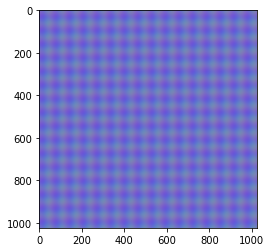

In [95]:
plt.imshow(normal_img.squeeze().cpu().numpy())
# plt.imsave("./data/cow_mesh/cow_normal.png", normal_img.squeeze().cpu().numpy())


In [18]:

# verts_uvs = mesh.textures.verts_uvs_padded().squeeze()  # (V, 2)
# faces_uvs = mesh.textures.faces_uvs_padded().squeeze()  # (F, 3)
# normal_mapUV = TexturesUV(
#     verts_uvs=[verts_uvs], faces_uvs=[faces_uvs], maps=normal_img
# )

#### Let's visualize the texture map

torch.Size([1, 1024, 1024, 3])


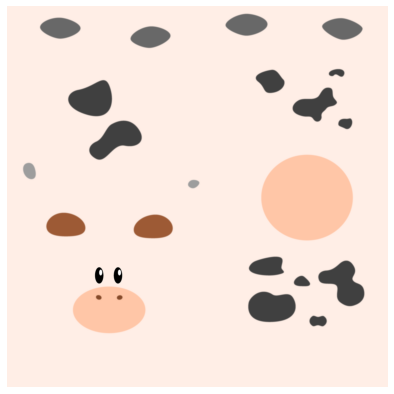

In [19]:
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

torch.Size([1, 1024, 1024, 3])


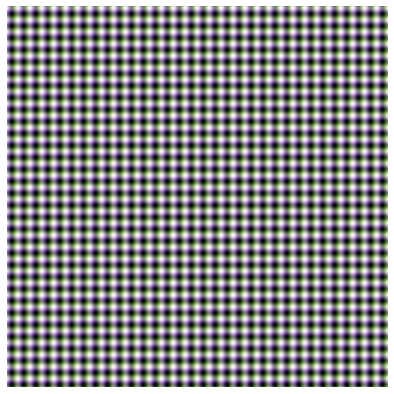

In [20]:
plt.figure(figsize=(7,7))
texture_image=mesh.normalmaps.maps_padded()
print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

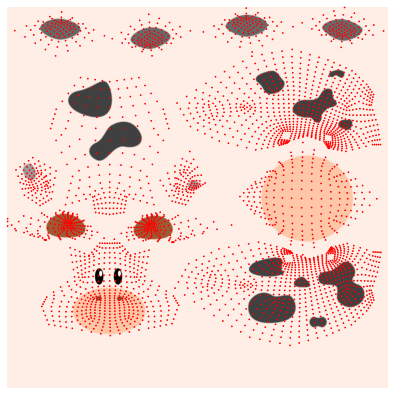

In [ ]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off");

## 2. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **Phong shading**. Then we learn how to vary different components using the modular API.  

# Blinn phong shading from https://github.com/facebookresearch/pytorch3d/issues/174

# New Phong Shading

In [ ]:
from typing import Tuple
from torch import nn
import torch.nn.functional as F
from pytorch3d.renderer.utils import TensorProperties, convert_to_tensors_and_broadcast
from pytorch3d.ops import interpolate_face_attributes

from typing import Optional
from pytorch3d.common.types import Device
from pytorch3d.structures.meshes import Meshes
from pytorch3d.renderer.blending import (
    BlendParams,
    hard_rgb_blend,
    sigmoid_alpha_blend,
    softmax_rgb_blend,
)
from pytorch3d.renderer.lighting import PointLights
from pytorch3d.renderer.materials import Materials
from pytorch3d.renderer.utils import TensorProperties
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import flat_shading, gouraud_shading, phong_shading

class NewSoftPhongShader(nn.Module):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function returns the
    soft aggregated color using all the faces per pixel.

    To use the default values, simply initialize the shader with the desired
    device e.g.

    .. code-block::

        shader = SoftPhongShader(device=torch.device("cuda:0"))
    """

    def __init__(
        self,
        device: Device = "cpu",
        cameras: Optional[TensorProperties] = None,
        lights: Optional[TensorProperties] = None,
        materials: Optional[Materials] = None,
        blend_params: Optional[BlendParams] = None,
    ) -> None:
        super().__init__()
        self.lights = lights if lights is not None else PointLights(device=device)
        self.materials = (
            materials if materials is not None else Materials(device=device)
        )
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    def to(self, device: Device):
        # Manually move to device modules which are not subclasses of nn.Module
        cameras = self.cameras
        if cameras is not None:
            self.cameras = cameras.to(device)
        self.materials = self.materials.to(device)
        self.lights = self.lights.to(device)
        return self

    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of SoftPhongShader"
            raise ValueError(msg)

        texels = meshes.sample_textures(fragments)
        mapped_normals = meshes.sample_normalmaps(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = new_phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
            mapped_normals=mapped_normals,
        )
        znear = kwargs.get("znear", getattr(cameras, "znear", 1.0))
        zfar = kwargs.get("zfar", getattr(cameras, "zfar", 100.0))
        images = softmax_rgb_blend(
            colors, fragments, blend_params, znear=znear, zfar=zfar
        )
        return images


def new_phong_shading(
    meshes, fragments, lights, cameras, materials, texels, mapped_normals=None
) -> torch.Tensor:
    """
    Apply per pixel shading. First interpolate the vertex normals and
    vertex coordinates using the barycentric coordinates to get the position
    and normal at each pixel. Then compute the illumination for each pixel.
    The pixel color is obtained by multiplying the pixel textures by the ambient
    and diffuse illumination and adding the specular component.

    Args:
        meshes: Batch of meshes
        fragments: Fragments named tuple with the outputs of rasterization
        lights: Lights class containing a batch of lights
        cameras: Cameras class containing a batch of cameras
        materials: Materials class containing a batch of material properties
        texels: texture per pixel of shape (N, H, W, K, 3)

    Returns:
        colors: (N, H, W, K, 3)
    """
    verts = meshes.verts_packed()  # (V, 3)
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_verts = verts[faces]
    faces_normals = vertex_normals[faces]
    pixel_coords = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_verts
    )
    pixel_normals = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_normals
    )
    
    # Assume point light source for now
    light_direction = lights.location - pixel_coords
    distance_squared = (light_direction.norm(p=2, dim=-1) ** 2.0).clamp_min(1e-6)
    light_direction = F.normalize(light_direction, p=2, dim=-1, eps=1e-6)
    
    # Tensor conversion
    matched_tensors = convert_to_tensors_and_broadcast(
        pixel_normals, 
        lights.diffuse_color,
        lights.specular_color,
        light_direction,
        cameras.get_camera_center(),
        materials.shininess,
        device=pixel_normals.device)
    
    # Reshape tensors
    points_dims = pixel_normals.shape[1:-1]
    expand_dims = (-1,) + (1,) * len(points_dims)
    for i, tensor in enumerate(matched_tensors): 
        if tensor.shape != pixel_normals.shape:
            matched_tensors[i] = tensor.view(
                expand_dims if i==len(matched_tensors)-1 else expand_dims + (3,)
            )   # Careful reshaping shininess
    
    normals, light_diffuse_color, light_specular_color, \
        light_direction, camera_position, shininess = matched_tensors
    
    #   Apply lighting
    view_direction = camera_position - pixel_coords
    view_direction = F.normalize(view_direction, p=2, dim=-1, eps=1e-6)
    # normals = F.normalize()
    # print(normals.shape, texels.shape, mapped_normals.shape)
    normals = F.normalize(normals, p=2, dim=-1, eps=1e-6)
    # print(normals.shape)

    diffuse_intensity = \
        F.relu(torch.sum(mapped_normals * light_direction, dim=-1)) / distance_squared
    light_diffuse = light_diffuse_color * diffuse_intensity[..., None]
    
    halfway_vector = light_direction + view_direction
    halfway_vector = F.normalize(halfway_vector, p=2, dim=-1, eps=1e-6)
    specular_intensity = (F.relu(
        torch.sum(mapped_normals * halfway_vector, dim=-1)
    ) ** shininess) / distance_squared
    light_specular = light_specular_color * specular_intensity[..., None]


    
    ambient_color = materials.ambient_color * lights.ambient_color
    diffuse_color = materials.diffuse_color * light_diffuse
    specular_color = materials.specular_color * light_specular

    if pixel_normals.dim() == 2 and pixel_coords.dim() == 2:
        # If given packed inputs remove batch dim in output.
        return (
            ambient_color.squeeze(),
            diffuse_color.squeeze(),
            specular_color.squeeze(),
        )

    if ambient_color.ndim != diffuse_color.ndim:
        # Reshape from (N, 3) to have dimensions compatible with
        # diffuse_color which is of shape (N, H, W, K, 3)
        ambient_color = ambient_color[:, None, None, None, :]

    colors = (ambient_color + diffuse_color) * texels + specular_color
    return colors
    


In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 1.0, -0.5]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=NewSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [ ]:
images = renderer(mesh)
print(mesh.verts_normals_packed().shape)

torch.Size([2930, 3])


## 3. Render the mesh

The light is in front of the object so it is bright and the image has specular highlights.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


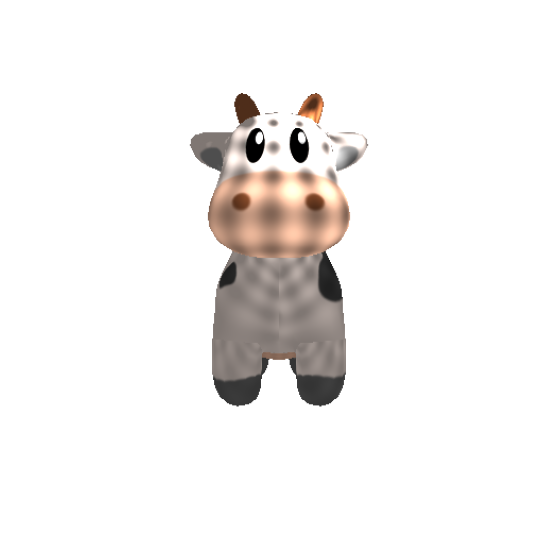

In [17]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## 4. Move the light behind the object and re-render

We can pass arbitrary keyword arguments to the `rasterizer`/`shader` via the call to the `renderer` so the renderer does not need to be reinitialized if any of the settings change/

In this case, we can simply update the location of the lights and pass them into the call to the renderer. 

The image is now dark as there is only ambient lighting, and there are no specular highlights.

In [ ]:
# Now move the light so it is on the +Z axis which will be behind the cow. 
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


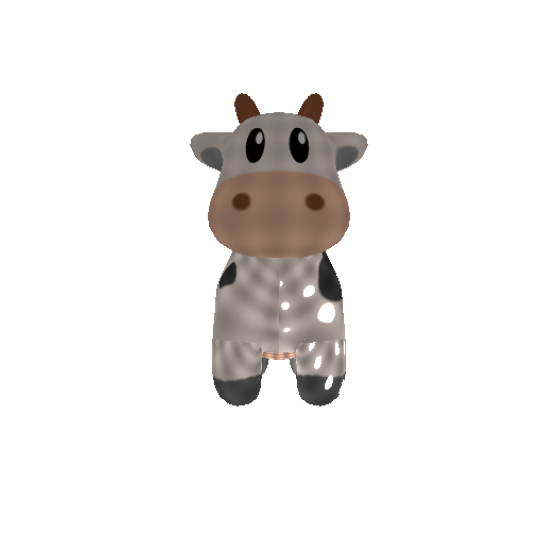

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## 5. Rotate the object, modify the material properties or light properties

We can also change many other settings in the rendering pipeline. Here we:

- change the **viewing angle** of the camera
- change the **position** of the point light
- change the **material reflectance** properties of the mesh

In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[0.0, 1.0, -0.5]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


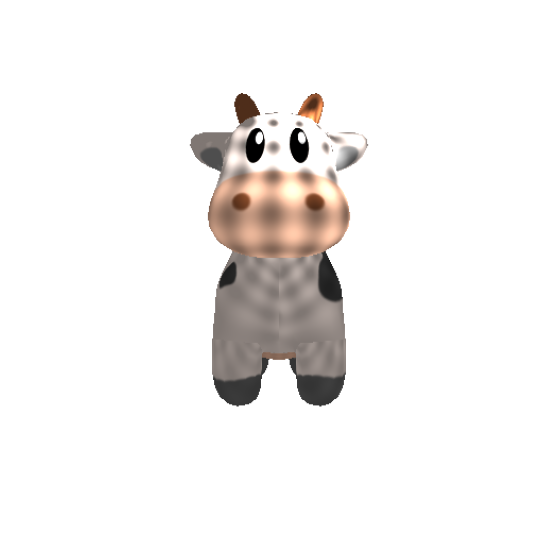

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## 6. Batched Rendering

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**. 
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


In [19]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[1.0, 1.0, -1.0]], device=device)

In [20]:
# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


ValueError: Meshes does not have normalmaps

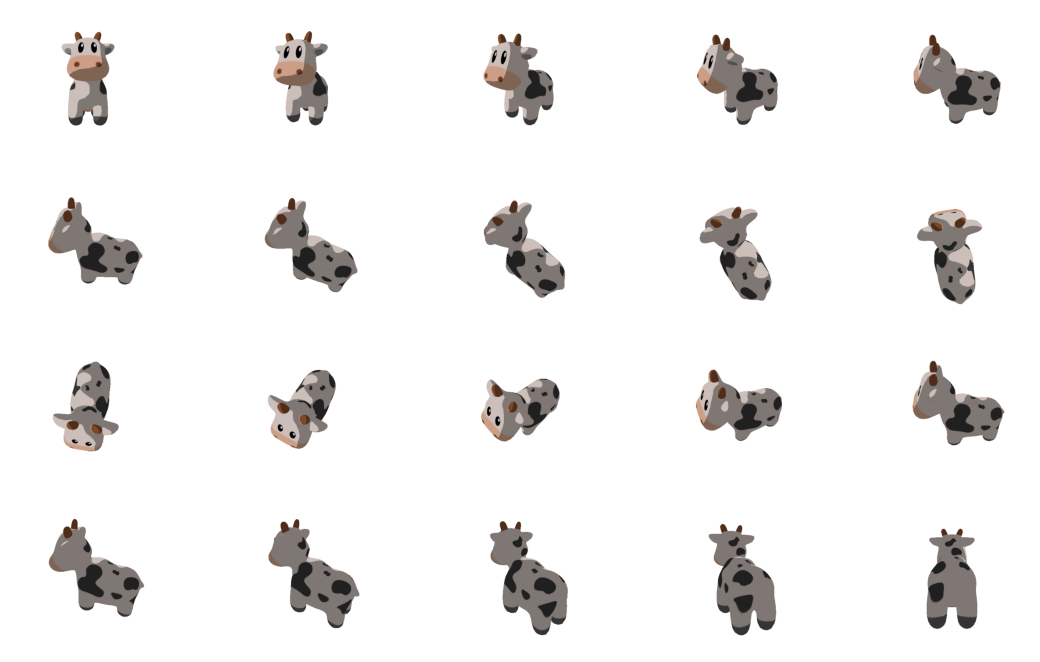

In [94]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

## 8. Conclusion
In this tutorial we learnt how to **load** a textured mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, and modify several components of the rendering pipeline. We also learned how to render Meshes in Plotly figures.